In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True)

### merge M14 with LAMOST DR6

In [3]:
dlam = pd.read_csv("/Users/k_masuda/Dropbox/astrodata/lamost/dr6_kplr.csv", delimiter="|")
dlam = dlam.rename({"# kepid": "kepid"}, axis='columns')

In [4]:
dm14 = pd.read_csv("data/mcquillan+14.tsv", delimiter="|", comment="#")
dm14["kepid"] = dm14.KIC
print (len(dm14), "stars in MqQuillan catalog.")

34030 stars in MqQuillan catalog.


In [5]:
plotdir = 'mcquillan_sample_plots/'

### check RV difference

In [6]:
drot = pd.merge(dm14, dlam, on='kepid', how='left')
print (len(drot), "stars in M14-LAMOST DR6 including duplications.")

37685 stars in M14-LAMOST DR6 including duplications.


In [7]:
rvmin = drot.groupby("kepid", as_index=False).min()[["kepid", "rv"]].rename({"rv": "rvmin"}, axis='columns')
rvmax = drot.groupby("kepid", as_index=False).max()[["kepid", "rv"]].rename({"rv": "rvmax"}, axis='columns')

In [102]:
len(rvmin)

34030

In [8]:
dupids = np.array(drot.kepid[drot.duplicated("kepid", keep='first')])
drv = pd.merge(rvmin, rvmax, on='kepid')
drv['dup'] = drv.kepid.isin(dupids)
drv['rvdiff'] = drv['rvmax'] - drv['rvmin']

SD of RV difference (km/s): 10.061661591729097


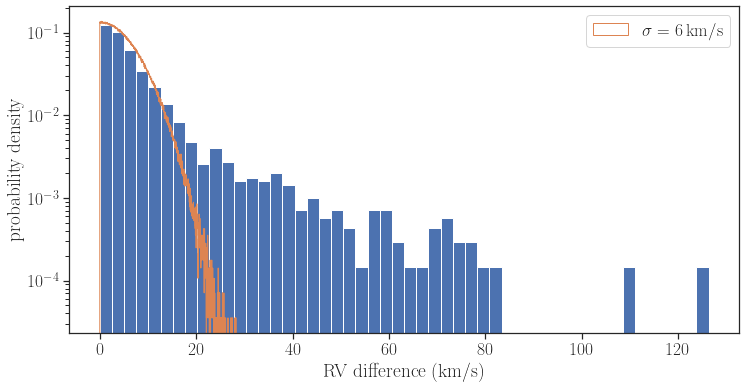

In [9]:
rnds = np.random.randn(int(1e6))*6
print ("SD of RV difference (km/s):", np.std(drv.rvdiff[drv.dup]))
plt.xlabel("RV difference (km/s)")
plt.ylabel("probability density")
plt.yscale("log")
plt.hist(drv.rvdiff[drv.dup], bins=50, density=True)
plt.hist(np.abs(rnds), density=True, bins=1000, histtype='step', label='$\sigma=6\,\mathrm{km/s}$')
plt.legend()
plt.savefig(plotdir+"rvdiff.png", dpi=200, bbox_inches="tight")

In [103]:
print (len(dlam.groupby('kepid', as_index=False).mean()), "Kepler stars in LAMOST DR6.")

61280 Kepler stars in LAMOST DR6.


In [10]:
drot = pd.merge(dm14, dlam.groupby('kepid', as_index=False).mean().reset_index(drop=True), on='kepid')
drot = pd.merge(drot, drv, on='kepid')
print (len(drot), "stars in the sample.")

8772 stars in the sample.


### xmatch with Gaia, remove photometric binaries and evolved stars

In [11]:
dgaia = pd.read_csv("data/kepler_gaiaedr3_cds.csv")
dgaia['kepid'] = dgaia.KIC
dkic = pd.read_csv("/Users/k_masuda/Dropbox/research_notes/data/kepler_stellar_17.csv", comment='#', delimiter="|")
dgaia = pd.merge(dgaia, dkic[['kepid', 'kepmag']], on='kepid')

In [12]:
print (len(dgaia), "Gaia matches within 5 arcsec.")

267750 Gaia matches within 5 arcsec.


In [13]:
d = pd.merge(drot, dgaia, how='left', on='kepid')
d['darcsec'] = d.angDist
d['GminK'] = d.phot_g_mean_mag - d.kepmag
d['mg'] = d.phot_g_mean_mag + 5 * np.log10(d.parallax) - 10

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
print (len(d), 'sources.')
print (np.sum(d.duplicated("kepid")), 'duplications.')

12215 sources.
3443 duplications.


In [15]:
def check_multis(d):
    plt.xlabel("distance (arcsec)")
    plt.ylabel("$G-K_p$")
    plt.xscale("log")
    plt.plot(d.darcsec, d.GminK, '.')
    kepids = list(d.kepid[d.kepid.duplicated(keep="first")])
    for _kepid in kepids:
        _idx = d.kepid==_kepid
        plt.plot(d.darcsec[_idx], d.GminK[_idx], 'o-', mfc="none", color="C1", lw=0.)

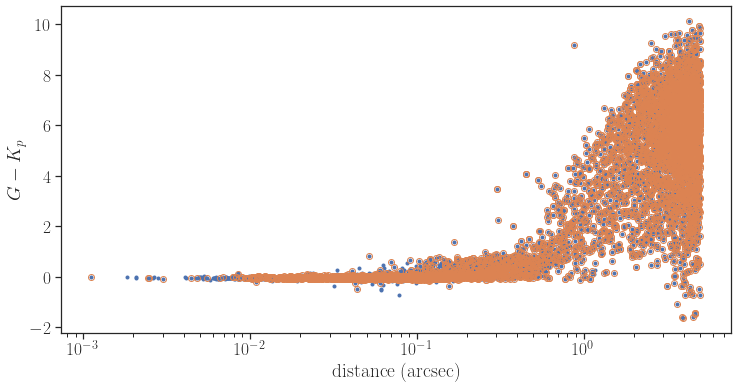

In [16]:
check_multis(d)

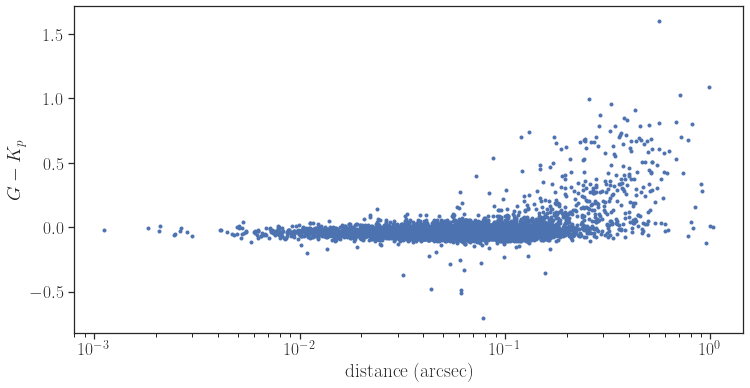

In [17]:
d1 = d.sort_values("darcsec", ascending=True).drop_duplicates("kepid", keep="first").reset_index(drop=True)
d1 = d1[d1.parallax_over_error>10].reset_index(drop=True)
check_multis(d1)

In [116]:
snp.abs(d1.GminK), [0.5,99,99.5])

array([5.7508000e-04, 4.2495444e-01, 6.4381466e-01])

In [124]:
print (len(d1), "sources with Gaia info.")
print ("mean and standard dev of G minus K:", np.mean(d1.GminK), np.std(d1.GminK))
print ("mean and 99% distance:", np.mean(d1.darcsec), np.percentile(d1.darcsec, 99))

8309 sources with Gaia info.
mean and standard dev of G minus K: -0.022788136719219938 0.08739525627877252
mean and 99% distance: 0.08331857612227725 0.4173485600000001


In [18]:
def iterative_fit(x, y, order, nsigma=[1.,3.], maxniter=10):
    A = np.vander(x, order+1)
    idx = np.ones_like(x) > 0
    for i in range(maxniter):
        w = np.linalg.solve(np.dot(A[idx].T, A[idx]), np.dot(A[idx].T, y[idx]))
        mu = np.dot(A, w)
        res = y - mu
        sigma = np.sqrt(np.median(res**2))
        idx_new = (res > -nsigma[0]*sigma) & (res < nsigma[1]*sigma)
        if np.sum(idx)==np.sum(idx_new):
            idx = idx_new
            break
        idx = idx_new
    return mu, w

In [19]:
idx = (d1.teff>4000) & (d1.teff<6500) & (d1.mg>0)
x, y = np.array((d1.teff[idx]-5500)/500), np.array(d1.mg[idx])
t0 = np.linspace(4000, 6500, 100)
x0 = (t0 - 5500) / 500.

In [20]:
order = 5
mu, w = iterative_fit(x, y, order)
msfunc = lambda teff: np.dot(np.vander((teff - 5500) / 500., order+1), w)

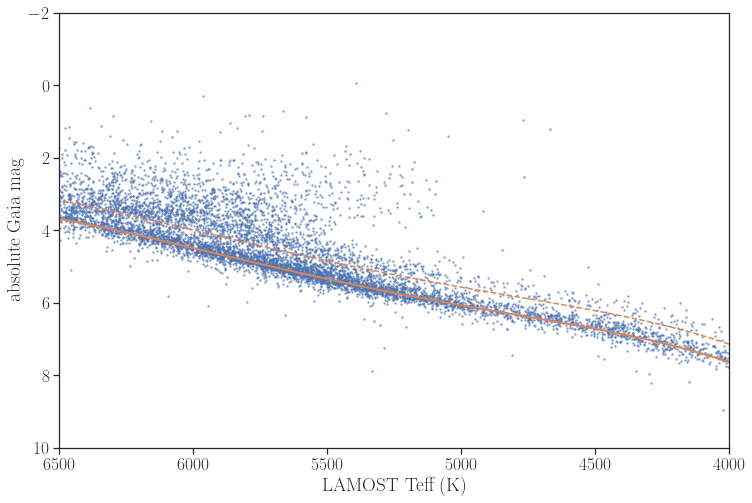

In [21]:
plt.figure(figsize=(12,8))
plt.xlabel("LAMOST Teff (K)")
plt.ylabel("absolute Gaia mag")
plt.xlim(6500, 4000)
plt.ylim(10, -2)
plt.plot(d1.teff, d1.mg, '.', markersize=3, alpha=0.5)
#plt.plot(t0, func((t0-5500)/500.), '-')
plt.plot(t0, msfunc(t0), '-', color='C1', lw=2)
plt.plot(t0, msfunc(t0)-0.5, '--', color='C1')
plt.savefig(plotdir+"mg_teff_all.png", dpi=200, bbox_inches="tight")

In [22]:
idxrv = d1.rvdiff > 20
#idxmg = d1.mg < msfunc(d1.teff)-0.5
idxmg = np.abs(d1.mg - msfunc(d1.teff)) > 0.5
idxt = (d1.teff>4000) & (d1.teff<6500)
idx = ((~idxrv) & (~idxmg)) & idxt 
#idx &= (d1.ruwe<1.4)

In [128]:
print ("after M_G and teff cut:", np.sum(~idxmg&idxt))
print ("after M_G and teff cut:", np.sum((~idxmg)&idxt&(~idxrv)))

after M_G and teff cut: 5022
after M_G and teff cut: 4977


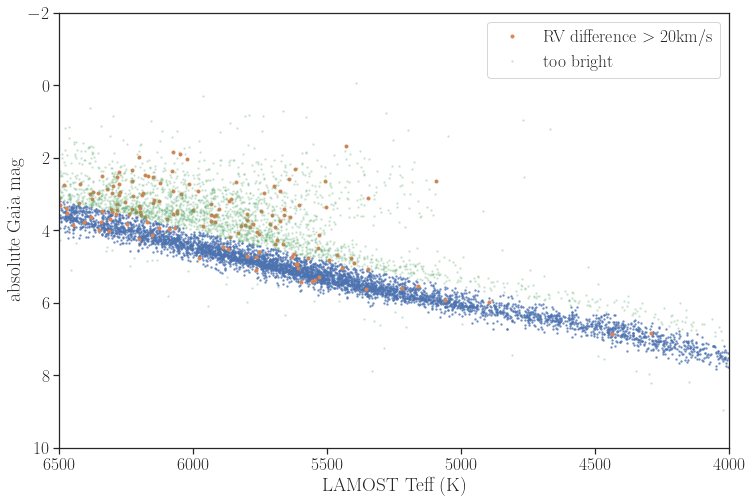

In [23]:
plt.figure(figsize=(12,8))
plt.xlabel("LAMOST Teff (K)")
plt.ylabel("absolute Gaia mag")
plt.xlim(6500, 4000)
plt.ylim(10, -2)
plt.plot(d1.teff[idx], d1.mg[idx], '.', markersize=3, alpha=0.6)
plt.plot(d1.teff[idxrv], d1.mg[idxrv], '.', label='RV difference $> 20$km/s')
plt.plot(d1.teff[idxmg], d1.mg[idxmg], '.', alpha=0.2, color='C2', markersize=3, label='too bright')
plt.legend(loc='best')
plt.savefig(plotdir+"mg_teff_cut.png", dpi=200, bbox_inches="tight")

In [72]:
def logg_teff_cut(teff):
    if teff>6200:
        return 4.1
    elif teff>5400:
        return 4.1 + 0.3*(6200.-teff)/800.
    else:
        return 4.4
t0 = np.linspace(4000, 6500, 100)
logg0 = np.array([logg_teff_cut(_t0) for _t0 in t0])

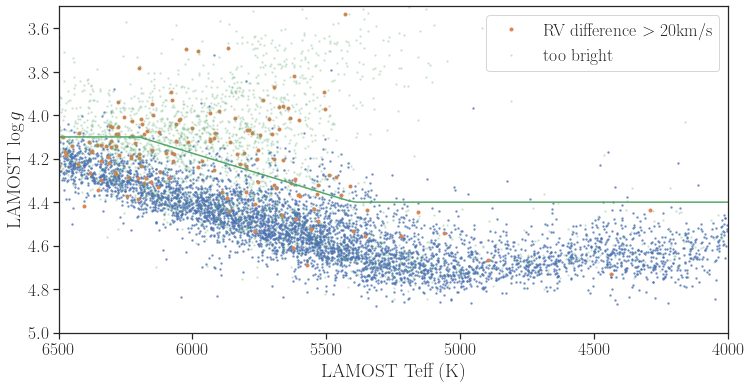

In [74]:
plt.xlabel("LAMOST Teff (K)")
plt.ylabel("LAMOST $\log g$")
plt.xlim(6500, 4000)
plt.ylim(5, 3.5)
plt.plot(d1.teff[idx], d1.logg[idx], '.', markersize=3, alpha=0.6)
plt.plot(d1.teff[idxrv], d1.logg[idxrv], '.', label='RV difference $> 20$km/s')
plt.plot(d1.teff[idxmg], d1.logg[idxmg], '.', alpha=0.2, color='C2', markersize=3, label='too bright')
plt.legend(loc='best')
#plt.plot(t0, logg0)
#plt.savefig(plotdir+"logg_teff_cut.png", dpi=200, bbox_inches="tight")

### assign Kepler precision and Rossby number

In [25]:
from scipy.interpolate import interp1d
dprec = pd.read_csv("data/kepler_precision.txt", delim_whitespace=True)
kepsigma = interp1d(dprec.kepmag, dprec.long, kind='cubic')

def tau_g98(teff):
    return 314.24 * np.exp(-(teff/1952.5)-(teff/6250.)**18) + 0.002

#def tau_w11(teff):
#    mass = teff_to_mass(teff)
#    logm = np.log10(mass)
#    logtau = 1.16 - 1.49 * logm - 0.54 * logm * logm
#    return 10**logtau

In [26]:
d1['kepler_sigma'] = kepsigma(d1.kepmag)
d1['tau'] = tau_g98(d1.teff)
d1['Rnorm'] = d1.Rper / d1.kepler_sigma
d1['Pnorm'] = d1.Prot / d1.tau

### plots

In [86]:
rnlabel = "variability amplitude $R_\mathrm{per}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = 'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'
col = 'gray'

In [87]:
dclean = d1[idx].reset_index(drop=True)

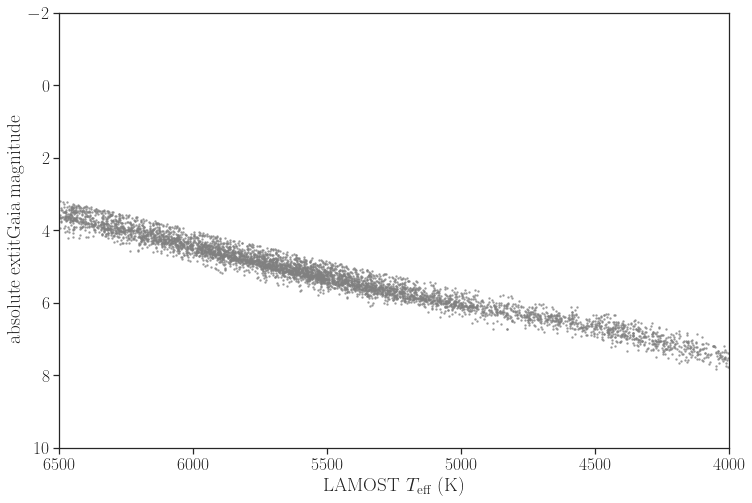

In [101]:
plt.figure(figsize=(12,8))
plt.xlabel(tefflabel)
plt.ylabel("absolute \textit{Gaia} magnitude")
plt.xlim(6500, 4000)
plt.ylim(10, -2)
plt.plot(dclean.teff, dclean.mg, '.', markersize=3, alpha=0.6, color=col)
#plt.plot(dclean.teff[idxg], dclean.mg[idxg], '.', markersize=10, alpha=0.6, label='$\log g<4$')
#plt.legend(loc='best')
plt.savefig(plotdir+"mg_teff_cut.png", dpi=200, bbox_inches="tight")

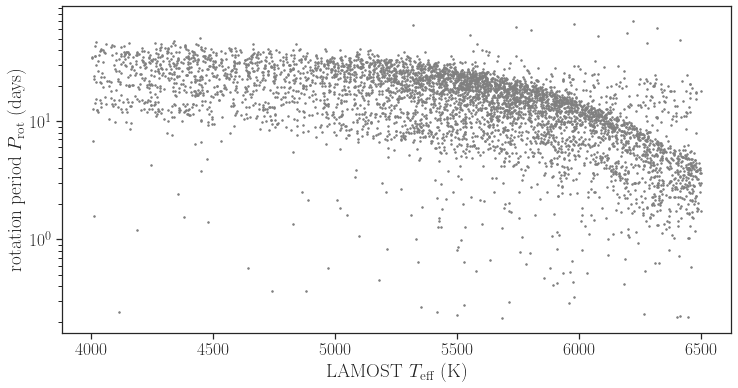

In [132]:
plt.xlabel(tefflabel)
plt.ylabel(protlabel)
plt.yscale("log")
plt.plot(dclean.teff, dclean.Prot, '.', markersize=3, color=col)
plt.savefig(plotdir+"prot_teff.png", dpi=200, bbox_inches="tight")

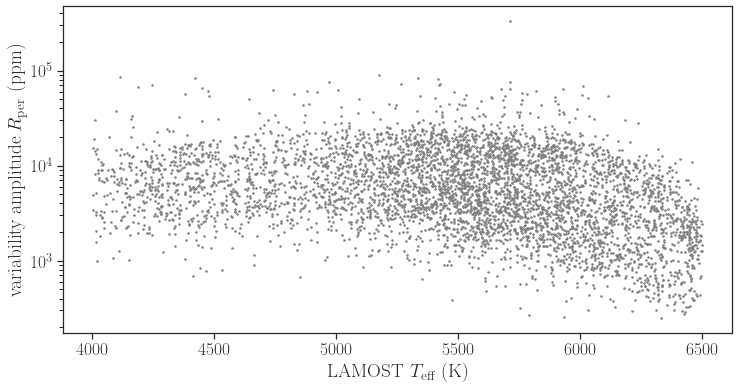

In [89]:
plt.xlabel(tefflabel)
plt.ylabel(rlabel)
plt.yscale("log")
plt.plot(dclean.teff, dclean.Rper, '.', markersize=3, color=col)
plt.savefig(plotdir+"rper_teff.png", dpi=200, bbox_inches="tight");

In [90]:
R_th = 3.

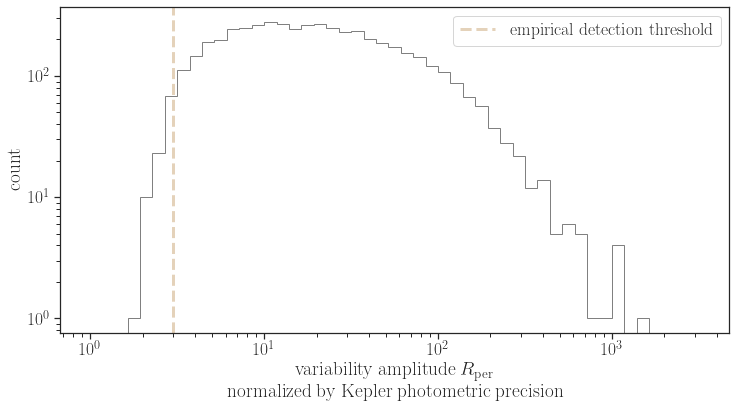

In [91]:
R1 = np.percentile(dclean.Rnorm, 2)
bins = np.logspace(0, 3.5, 50)
plt.xlabel(rnlabel)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("count")
plt.axvline(x=R_th, label=dtlabel, color='tan', lw=3, ls='dashed', alpha=0.6,)
plt.hist(dclean.Rnorm, bins=bins, histtype='step', lw=1, color=col)
plt.legend(loc='best')
plt.savefig(plotdir+"rper_hist.png", dpi=200, bbox_inches="tight")

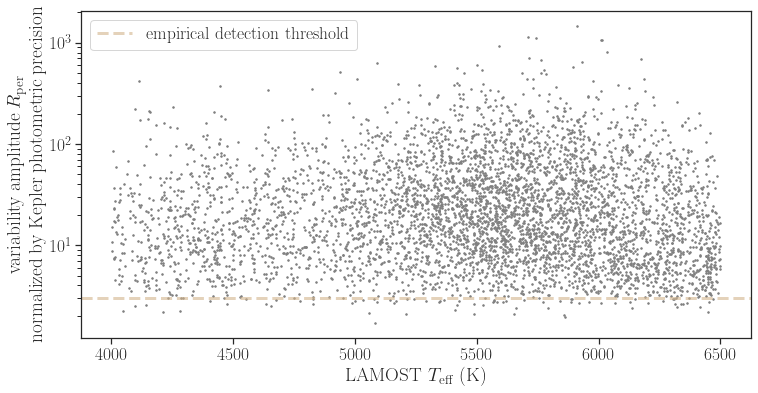

In [92]:
plt.xlabel(tefflabel)
plt.ylabel(rnlabel)
plt.yscale("log")
plt.plot(dclean.teff, dclean.Rnorm, '.', markersize=3, color=col)
plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
plt.legend(loc='best')
plt.savefig(plotdir+"rnorm_teff.png", dpi=200, bbox_inches="tight")

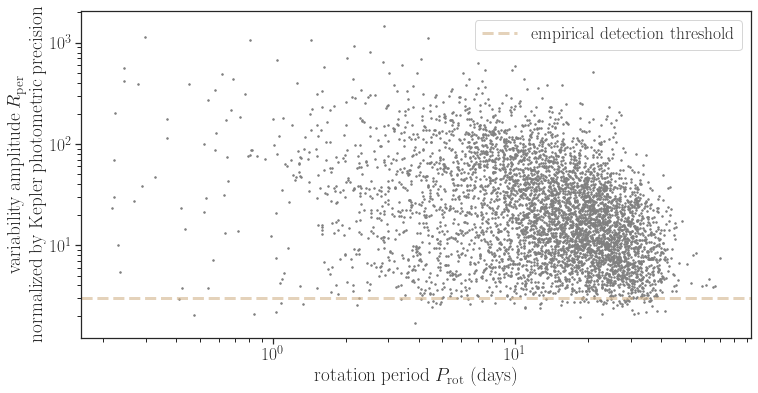

In [93]:
plt.xlabel(protlabel)
plt.ylabel(rnlabel)
plt.xscale("log")
plt.yscale("log")
plt.plot(dclean.Prot, dclean.Rnorm, '.', markersize=3, color=col)
plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
plt.legend(loc='best')
plt.savefig(plotdir+"rnorm_prot.png", dpi=200, bbox_inches="tight")

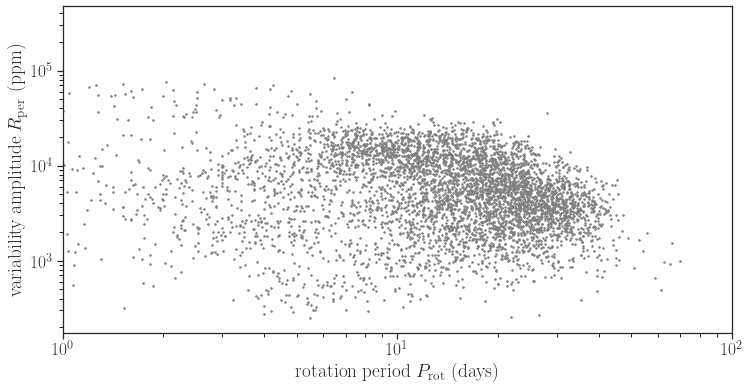

In [94]:
plt.xlim(1, 100)
plt.xlabel(protlabel)
plt.ylabel(rlabel)
plt.yscale("log")
plt.xscale("log")
plt.plot(dclean.Prot, dclean.Rper, '.', markersize=3, color=col)
plt.savefig(plotdir+"rper_prot.png", dpi=200, bbox_inches="tight")

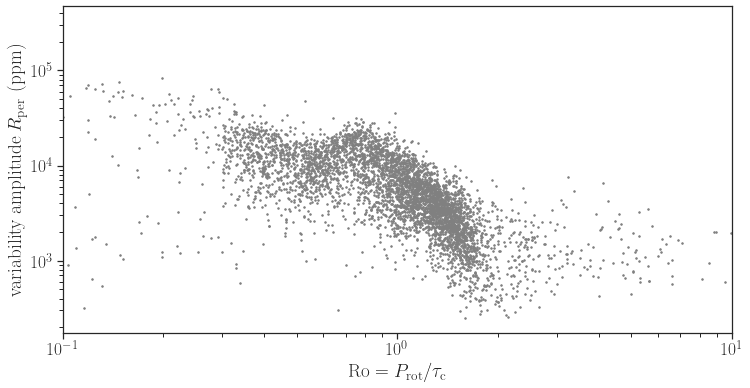

In [95]:
plt.xlabel(pnlabel)
plt.ylabel(rlabel)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0.1, 10)
plt.plot(dclean.Pnorm, dclean.Rper, '.', markersize=3, color=col)
plt.savefig(plotdir+"rper_ro.png", dpi=200, bbox_inches="tight")

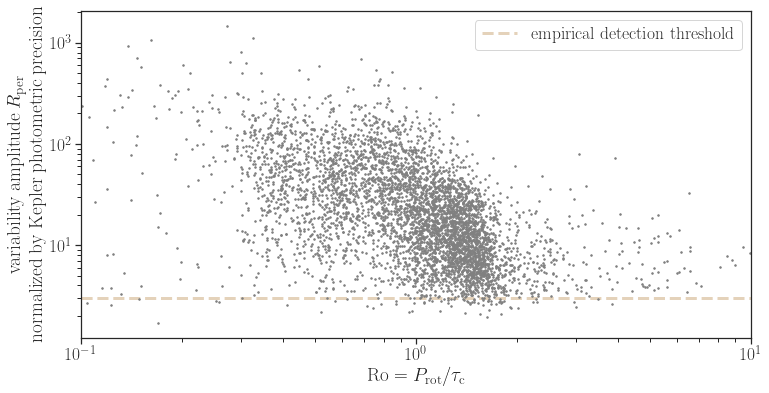

In [96]:
plt.xlabel(pnlabel)
plt.ylabel(rnlabel)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0.1, 10)
plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
plt.plot(dclean.Pnorm, dclean.Rnorm, '.', markersize=3, color=col)
plt.legend(loc='best')
plt.savefig(plotdir+"rnorm_ro.png", dpi=200, bbox_inches="tight")

In [40]:
d1.to_csv("sample_all.csv", index=False)
dclean.to_csv("sample_clean.csv", index=False)

In [97]:
len(dclean)

4977

In [47]:
idxg = dclean.logg < 4.2
dclean[idxg][['teff', 'logg', 'ruwe', 'rvdiff', 'Pnorm', 'Rper', 'Prot']]

,teff,logg,ruwe,rvdiff,Pnorm,Rper,Prot
20,6206.170,4.1880,1.391,0.00,1.457824,947.98,7.908
61,6445.745,4.1920,1.038,3.47,1.389554,1719.44,2.820
70,6269.720,4.1960,1.053,0.00,1.207373,2601.80,5.310
74,6453.115,4.1805,2.235,16.83,2.233366,696.00,4.355
81,6415.520,4.1980,1.043,0.00,1.906792,582.40,4.526
...,...,...,...,...,...,...,...
4676,6364.190,4.1380,3.551,0.00,6.601813,571.73,19.953
4806,5512.965,4.1540,0.914,1.87,1.180531,4840.34,19.850
4839,6302.510,4.1460,2.122,0.00,0.410309,2706.32,1.599
4862,6287.465,4.1545,1.601,9.24,0.312551,9997.96,1.289


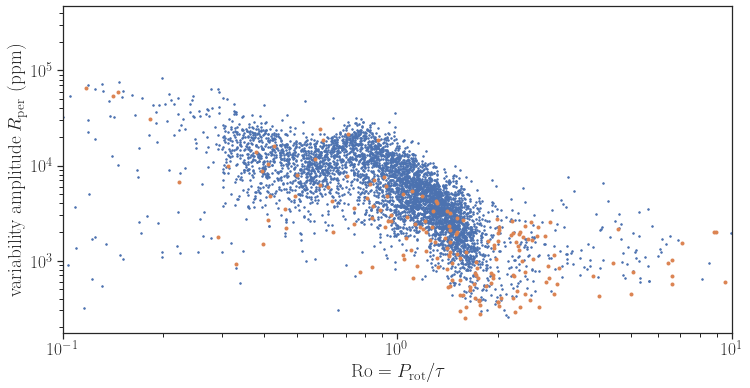

In [48]:
plt.xlabel(pnlabel)
plt.ylabel(rlabel)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0.1, 10)
plt.plot(dclean.Pnorm, dclean.Rper, '.', markersize=3)
plt.plot(dclean.Pnorm[idxg], dclean.Rper[idxg], 'o', markersize=3)
#plt.savefig(plotdir+"rper_ro.png", dpi=200, bbox_inches="tight")

In [133]:
tau_g98(5800)

12.419080073419664